### With the recent introduction of *Netflix’s household plan*, I aimed to analyze its impact on revenue and ARPU. Using Netflix’s quarterly ARPU, revenue, and membership data, I developed time series forecasting models to uncover revenue dynamics, regional trends, and growth patterns across US and Canada markets.

Key Metrics and Dimensions
1. UCAN ARPU (Average Revenue Per User): Total revenue divided by number of paid memberships in U.S. & Canada	Measures how much money Netflix makes from each user in that region
2. UCAN Streaming Revenue: Total revenue from streaming in U.S. & Canada

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

### Load and Prepare the Data

In [2]:
df = pd.read_csv("/content/netflix_revenue_updated-3.csv")

# Parse and format date
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%y")

# Sort by date (just in case)
df = df.sort_values("Date")

In [16]:
df.tail()

,Date,Global Revenue,UCAN Streaming Revenue,EMEA Streaming Revenue,LATM Streaming Revenue,APAC Streaming Revenue,UCAN Members,EMEA Members,LATM Members,APAC Members,UCAN ARPU,EMEA ARPU,LATM ARPU,APAC ARPU,Netflix Streaming Memberships
27,2023-12-31,8832825000,3594791000,2783530000,1156023000,962715000,80128000,88813000,45997000,45338000,16.64,10.75,8.60,7.31,"260,276,000.00"
28,2024-03-31,9370440000,4224315000,2958153000,1165008000,1022924000,82658000,91729000,47720000,47495000,17.30,10.92,8.29,7.35,"269,602,000.00"
29,2024-06-30,9559310000,4295560000,3007772000,1204145000,1051833000,84109000,93964000,49250000,50324000,17.17,10.80,8.28,7.17,"277,647,000.00"
30,2024-09-30,9824703000,4322476000,3133466000,1240892000,1127869000,84803000,96131000,49182000,52604000,17.06,10.99,8.40,7.31,"282,720,000.00"
31,2024-12-31,10246513000,4517018000,3287604000,1229771000,1212120000,89625000,101133000,53327000,57541000,17.26,11.11,8.00,7.34,"301,626,000.00"


## Forecasting UCAN Streaming Revenue (Prophet & ARIMA)

In [8]:
df_revenue = df[['Date', 'UCAN Streaming Revenue']].dropna()

# --- Prophet Forecast ---
df_prophet_rev = df_revenue.rename(columns={'Date': 'ds', 'UCAN Streaming Revenue': 'y'})

# Fit Prophet model
prophet_model_rev = Prophet()
prophet_model_rev.fit(df_prophet_rev)

# Forecast next 4 quarters
future_rev = prophet_model_rev.make_future_dataframe(periods=4, freq='Q')
forecast_prophet_rev = prophet_model_rev.predict(future_rev)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplb73lyaw/quwph6_g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplb73lyaw/_sgbmm39.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8196', 'data', 'file=/tmp/tmplb73lyaw/quwph6_g.json', 'init=/tmp/tmplb73lyaw/_sgbmm39.json', 'output', 'file=/tmp/tmplb73lyaw/prophet_modela_3jqh4o/prophet_model-20250520051422.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:14:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:14:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:c

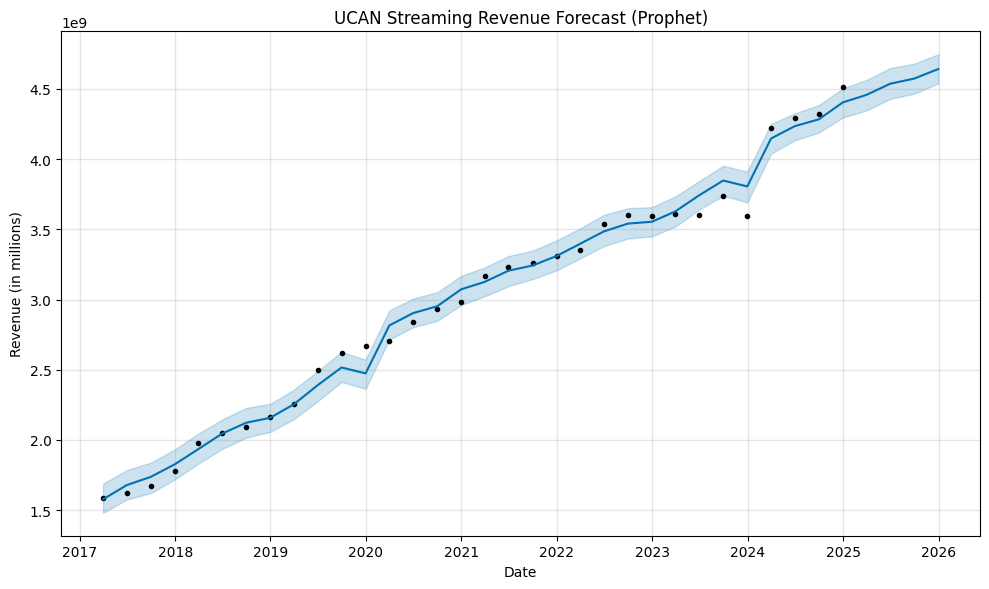

In [9]:
# Plot forecast
prophet_model_rev.plot(forecast_prophet_rev)
plt.title("UCAN Streaming Revenue Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Revenue (in millions)")
plt.tight_layout()
plt.show()

In [10]:
# Extract Q1 2025 forecast
q1_2025_prophet_rev = forecast_prophet_rev[forecast_prophet_rev['ds'] == '2025-03-31']['yhat'].values[0]

# --- ARIMA Forecast ---
df_arima_rev = df_revenue.copy()
df_arima_rev.set_index('Date', inplace=True)

# Fit ARIMA model
arima_model_rev = ARIMA(df_arima_rev['UCAN Streaming Revenue'], order=(1, 1, 1))
arima_result_rev = arima_model_rev.fit()

# Forecast 4 quarters
forecast_arima_rev = arima_result_rev.forecast(steps=4)
forecast_arima_rev.index = pd.date_range(start=df_arima_rev.index[-1] + pd.offsets.QuarterEnd(), periods=4, freq='Q')

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA paramete

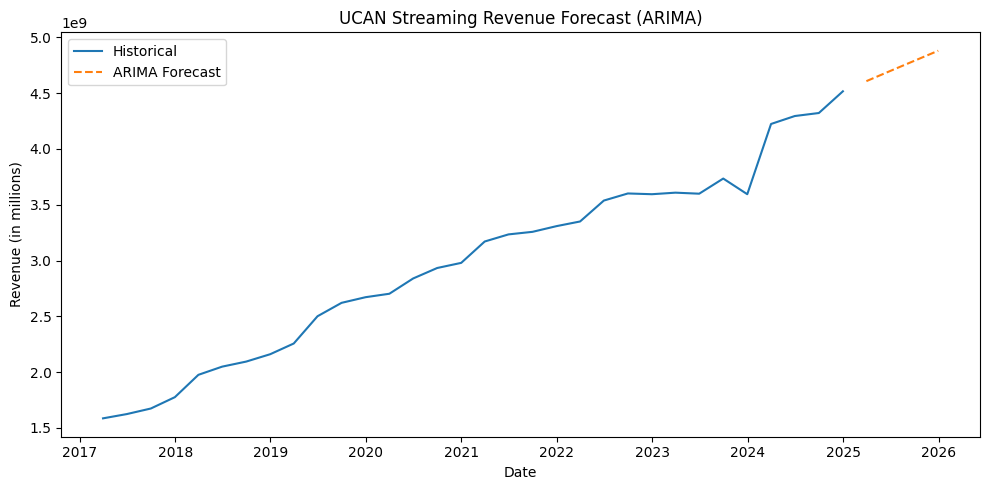

In [11]:
# Plot ARIMA forecast
plt.figure(figsize=(10, 5))
plt.plot(df_arima_rev.index, df_arima_rev['UCAN Streaming Revenue'], label='Historical')
plt.plot(forecast_arima_rev.index, forecast_arima_rev.values, label='ARIMA Forecast', linestyle='--')
plt.title("UCAN Streaming Revenue Forecast (ARIMA)")
plt.xlabel("Date")
plt.ylabel("Revenue (in millions)")
plt.legend()
plt.tight_layout()
plt.show()

### Revenue Forecast Comparison for Q1 2025

> ### Note: The actual UCAN Q1 2025 revenue value (4,625,884,000 USD) was sourced from Netflix's official quarterly earnings report: https://ir.netflix.net/financials/quarterly-earnings/default.aspx


In [15]:
actual_rev_q1_2025 =  4625884000

# Get ARIMA Q1 2025 forecast
q1_2025_arima_rev = forecast_arima_rev.iloc[0]

# Compare
results_rev = pd.DataFrame({
    'Model': ['Prophet', 'ARIMA'],
    'Q1 2025 Forecast': [q1_2025_prophet_rev, q1_2025_arima_rev],
    'Actual': [actual_rev_q1_2025, actual_rev_q1_2025]
})
results_rev['% Error'] = abs((results_rev['Q1 2025 Forecast'] - results_rev['Actual']) / results_rev['Actual']) * 100

print("\nForecast Comparison for Q1 2025 UCAN Streaming Revenue:\n")
pd.options.display.float_format = '{:,.2f}'.format
print(results_rev)



Forecast Comparison for Q1 2025 UCAN Streaming Revenue:

     Model  Q1 2025 Forecast      Actual  % Error
0  Prophet  4,457,885,390.72  4625884000     3.63
1    ARIMA  4,608,101,751.00  4625884000     0.38


### ARIMA delivered a highly accurate forecast, with less than 0.5% error.
> This confirms its suitability for stable financial trend modeling, especially when official revenue is available.
### Business Interpretation:
> UCAN revenue stayed strong in Q1 2025 despite pricing and household policy shifts, indicating effective monetization via subscription volume, even if per-user revenue may be diluted.

### Prophet Forecasting - UCAN ARPU

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 24.
DEBUG:cmdstanpy:input tempfile: /tmp/tmplb73lyaw/ovmkugdf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmplb73lyaw/hxwf4u_r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=12295', 'data', 'file=/tmp/tmplb73lyaw/ovmkugdf.json', 'init=/tmp/tmplb73lyaw/hxwf4u_r.json', 'output', 'file=/tmp/tmplb73lyaw/prophet_model0qhz9_3m/prophet_model-20250520050631.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
05:06:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
05:06:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:

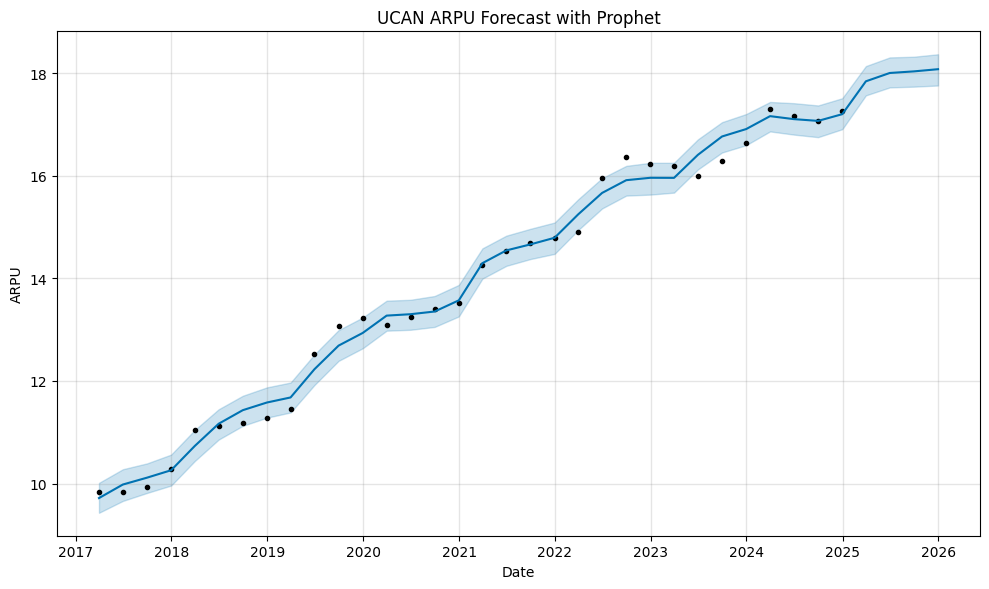

In [3]:
df_prophet = df[['Date', 'UCAN ARPU']].dropna().rename(columns={'Date': 'ds', 'UCAN ARPU': 'y'})

# Fit the model
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Forecast 4 future quarters
future = prophet_model.make_future_dataframe(periods=4, freq='Q')
forecast_prophet = prophet_model.predict(future)

# Plot forecast
prophet_model.plot(forecast_prophet)
plt.title("UCAN ARPU Forecast with Prophet")
plt.xlabel("Date")
plt.ylabel("ARPU")
plt.tight_layout()
plt.show()

In [4]:
# Extract forecast for 2025
forecast_2025_prophet = forecast_prophet[forecast_prophet['ds'].dt.year == 2025][['ds', 'yhat']]
print("Prophet UCAN ARPU Forecast (2025):")
print(forecast_2025_prophet)

Prophet UCAN ARPU Forecast (2025):
           ds       yhat
32 2025-03-31  17.838103
33 2025-06-30  18.000356
34 2025-09-30  18.031597
35 2025-12-31  18.074123


### ARIMA Forecasting - UCAN ARPU

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
<ipython-input-5-e6493263fbb5>:10: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_arima.index = pd.date_range(start=df_arima.index[-1] + pd.offsets.QuarterEnd(), periods=4, freq='Q')


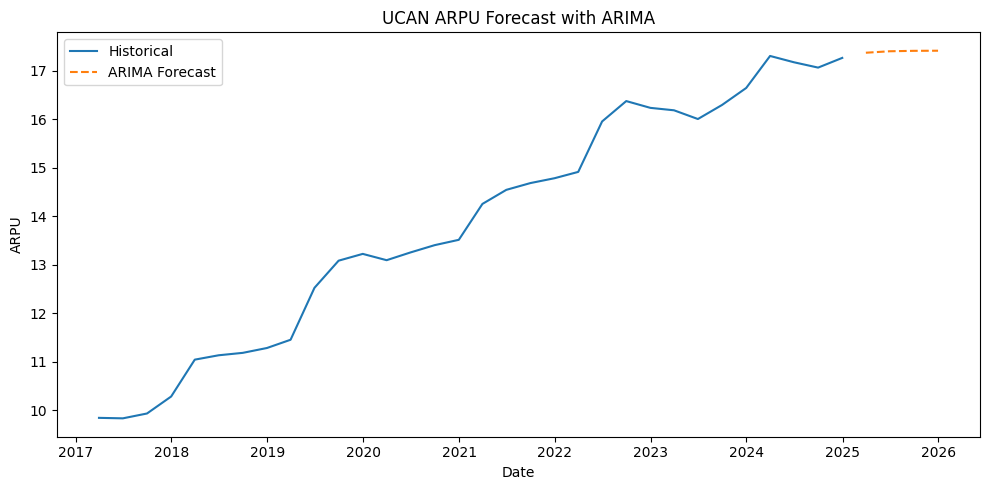

In [5]:
df_arima = df[['Date', 'UCAN ARPU']].dropna()
df_arima.set_index('Date', inplace=True)

# Fit ARIMA(1,1,1)
arima_model = ARIMA(df_arima['UCAN ARPU'], order=(1, 1, 1))
arima_result = arima_model.fit()

# Forecast next 4 quarters
forecast_arima = arima_result.forecast(steps=4)
forecast_arima.index = pd.date_range(start=df_arima.index[-1] + pd.offsets.QuarterEnd(), periods=4, freq='Q')

# Plot ARIMA forecast
plt.figure(figsize=(10, 5))
plt.plot(df_arima.index, df_arima['UCAN ARPU'], label='Historical')
plt.plot(forecast_arima.index, forecast_arima.values, label='ARIMA Forecast', linestyle='--')
plt.title("UCAN ARPU Forecast with ARIMA")
plt.xlabel("Date")
plt.ylabel("ARPU")
plt.legend()
plt.tight_layout()
plt.show()

### Forecast Comparison

In [6]:
# Actual UCAN ARPU for Q1 2025
actual_q1_2025 = 17.26

# Extract Q1 2025 forecasts
q1_date = pd.Timestamp('2025-03-31')
q1_prophet = forecast_2025_prophet[forecast_2025_prophet['ds'] == q1_date]['yhat'].values[0]
q1_arima = forecast_arima.iloc[0]

# Create comparison table
results = pd.DataFrame({
    'Model': ['Prophet', 'ARIMA'],
    'Q1 2025 Forecast': [q1_prophet, q1_arima],
    'Actual': [actual_q1_2025, actual_q1_2025],
})
results['% Error'] = abs((results['Q1 2025 Forecast'] - results['Actual']) / results['Actual']) * 100

print("\nForecast Comparison for Q1 2025 UCAN ARPU:\n")
print(results)


Forecast Comparison for Q1 2025 UCAN ARPU:

     Model  Q1 2025 Forecast  Actual   % Error
0  Prophet         17.838103   17.26  3.349380
1    ARIMA         17.366613   17.26  0.617689


### Evaluation Metrics (Historical Fit)

In [7]:
merged = pd.merge(forecast_prophet[['ds', 'yhat']], df_prophet, on='ds', how='inner')
mae = mean_absolute_error(merged['y'], merged['yhat'])
rmse = np.sqrt(mean_squared_error(merged['y'], merged['yhat']))
mape = mean_absolute_percentage_error(merged['y'], merged['yhat'])

print(f"\nProphet Model Metrics:")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape*100:.2f}%")


Prophet Model Metrics:
MAE: 0.19, RMSE: 0.23, MAPE: 1.37%
